In [3]:

    #%%
# Imports and Setup
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from datetime import datetime

# Set up matplotlib for better visualizations
plt.style.use('default')
%matplotlib inline

In [4]:
# Load the all_papers.json from corpus_12-08-25
print("Loading data...")
with open('corpus_12-08-25/corpus/train/all_papers.json', 'r') as f:
    data = json.load(f)

papers = data['data']
metadata = data['metadata']

print(f"✓ Loaded {len(papers):,} papers from dataset")
print(f"✓ Processing pipeline has {len(metadata)} stages")

Loading data...
✓ Loaded 373,716 papers from dataset
✓ Processing pipeline has 6 stages


# Entity Type Analysis

This notebook analyzes the different types of entities in the corpus_12-08-25 dataset.

In [14]:
ct = 0, done = False
for paper in papers:
    if "authors" in paper:
        authors = paper['authors']
        for author in authors:
            if "publication_history" in author and "263334020" in author["publication_history"]:
                print(paper)
                break
ct

{'corpus_id': '263334020', 'arxiv_id': '2310.00749', 'date': '2023-10-01', 'categories': ['cs.DB', 'cs.LG'], 'title': 'SEED: Domain-Specific Data Curation With Large Language Models', 'abstract': 'Data curation tasks that prepare data for analytics are critical for turning data into actionable insights. However, due to the diverse requirements of applications in different domains, generic off-the-shelf tools are typically insufficient. As a result, data scientists often have to develop domain-specific solutions tailored to both the dataset and the task, e.g. writing domain-specific code or training machine learning models on a sufficient number of annotated examples. This process is notoriously difficult and time-consuming. We present SEED, an LLM-as-compiler approach that automatically generates domain-specific data curation solutions via Large Language Models (LLMs). Once the user describes a task, input data, and expected output, the SEED compiler produces a hybrid pipeline that com

0

ENTITY TYPES BY ROLE
                                           Role  Count  Percentage
              target.author.publication_history 295897   79.176969
target.author.publication_history.key_reference 149314   39.953869
                           target.key_reference  50653   13.553875
                                         target  44990   12.038553

Total unique role types: 4


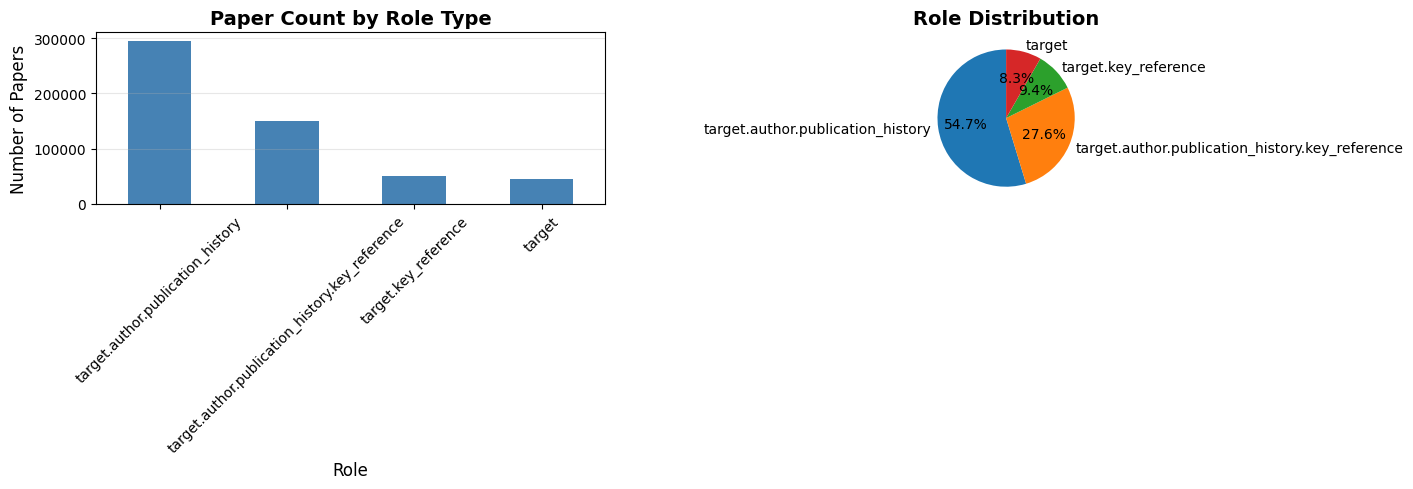

In [3]:
## 1. Entity Type Analysis - Role Distribution

# Count papers by role type
role_counter = Counter()
for paper in papers:
    for role in paper.get('roles', []):
        role_counter[role] += 1

# Create DataFrame for better visualization
role_df = pd.DataFrame([
    {'Role': role, 'Count': count, 'Percentage': count/len(papers)*100}
    for role, count in role_counter.most_common()
])

print("=" * 80)
print("ENTITY TYPES BY ROLE")
print("=" * 80)
print(role_df.to_string(index=False))
print(f"\nTotal unique role types: {len(role_counter)}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
role_df.plot(x='Role', y='Count', kind='bar', ax=ax1, legend=False, color='steelblue')
ax1.set_title('Paper Count by Role Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Role', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(role_df['Count'], labels=role_df['Role'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Role Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

DATA COMPLETENESS BY ROLE
                                           Role  Total Papers  Has Key Refs % Key Refs  Has Authors % Authors  Has Pub History % Pub History
target.author.publication_history.key_reference        149314         65576      43.9%        83399     55.9%             3567          2.4%
              target.author.publication_history        295897        199185      67.3%       295897    100.0%            35022         11.8%
                           target.key_reference         50653         32624      64.4%        37620     74.3%             3897          7.7%
                                         target         44990         44990     100.0%        44990    100.0%            44990        100.0%


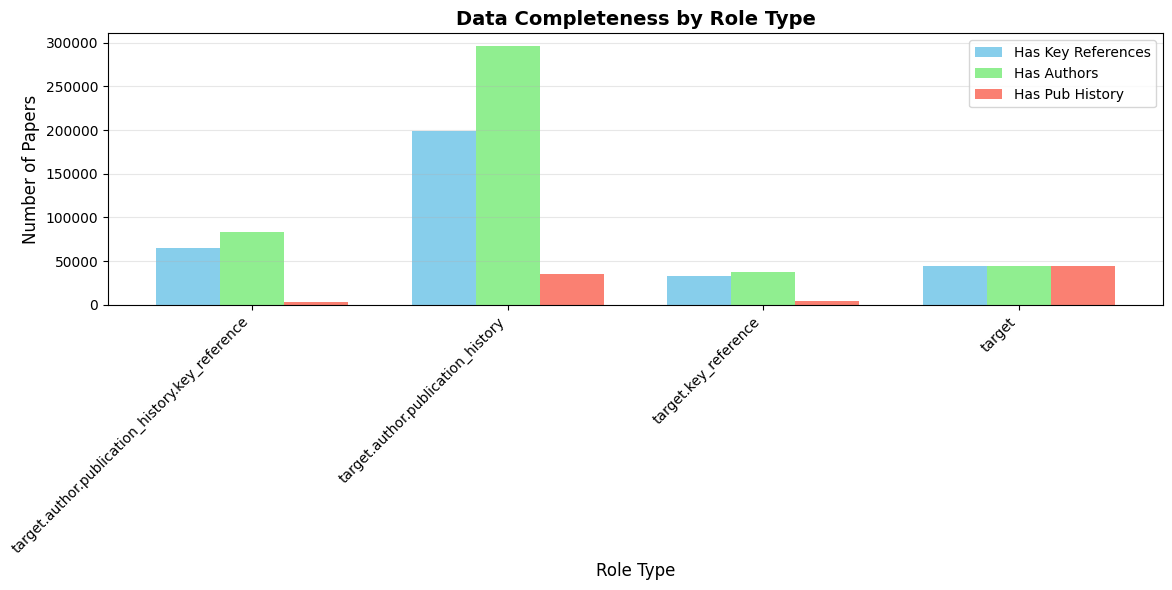

In [4]:
## 2. Data Completeness Analysis by Role

# Analyze completeness for each role type
completeness_data = []

for role in role_counter.keys():
    # Get papers with this role
    role_papers = [p for p in papers if role in p.get('roles', [])]
    
    total = len(role_papers)
    has_key_refs = sum(1 for p in role_papers if p.get('key_references'))
    has_authors = sum(1 for p in role_papers if p.get('authors'))
    has_pub_history = sum(1 for p in role_papers 
                          if p.get('authors') and any('publication_history' in a for a in p['authors']))
    
    completeness_data.append({
        'Role': role,
        'Total Papers': total,
        'Has Key Refs': has_key_refs,
        '% Key Refs': f"{has_key_refs/total*100:.1f}%",
        'Has Authors': has_authors,
        '% Authors': f"{has_authors/total*100:.1f}%",
        'Has Pub History': has_pub_history,
        '% Pub History': f"{has_pub_history/total*100:.1f}%"
    })

completeness_df = pd.DataFrame(completeness_data)

print("=" * 80)
print("DATA COMPLETENESS BY ROLE")
print("=" * 80)
print(completeness_df.to_string(index=False))

# Visualize completeness
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(completeness_data))
width = 0.25

has_refs = [d['Has Key Refs'] for d in completeness_data]
has_auth = [d['Has Authors'] for d in completeness_data]
has_hist = [d['Has Pub History'] for d in completeness_data]
labels = [d['Role'] for d in completeness_data]

ax.bar(x - width, has_refs, width, label='Has Key References', color='skyblue')
ax.bar(x, has_auth, width, label='Has Authors', color='lightgreen')
ax.bar(x + width, has_hist, width, label='Has Pub History', color='salmon')

ax.set_xlabel('Role Type', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.set_title('Data Completeness by Role Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

AUTHOR ENTITY ANALYSIS
Total unique authors: 388,712
Papers with authors: 306,045

Authors per paper:
  Mean: 10.91
  Median: 4.0
  Min: 0
  Max: 5278

Publication history lengths:
  Mean: 22.52
  Median: 7.0
  Min: 0
  Max: 659

Top 10 Most Prolific Authors (by paper count in dataset):
   1. Y. Zhang                                 - 1038 papers,   0 in history
   2. Z. Li                                    - 1002 papers,   0 in history
   3. L. Li                                    - 957 papers,   0 in history
   4. Zheng Wang                               - 943 papers,   0 in history
   5. Hengne Li                                - 926 papers,   0 in history
   6. Z. Xu                                    - 893 papers,   0 in history
   7. Yueh-Feng Liu                            - 879 papers,   0 in history
   8. M. Wang                                  - 853 papers,   0 in history
   9. D. Golubkov                              - 825 papers,   0 in history
  10. J. Wang             

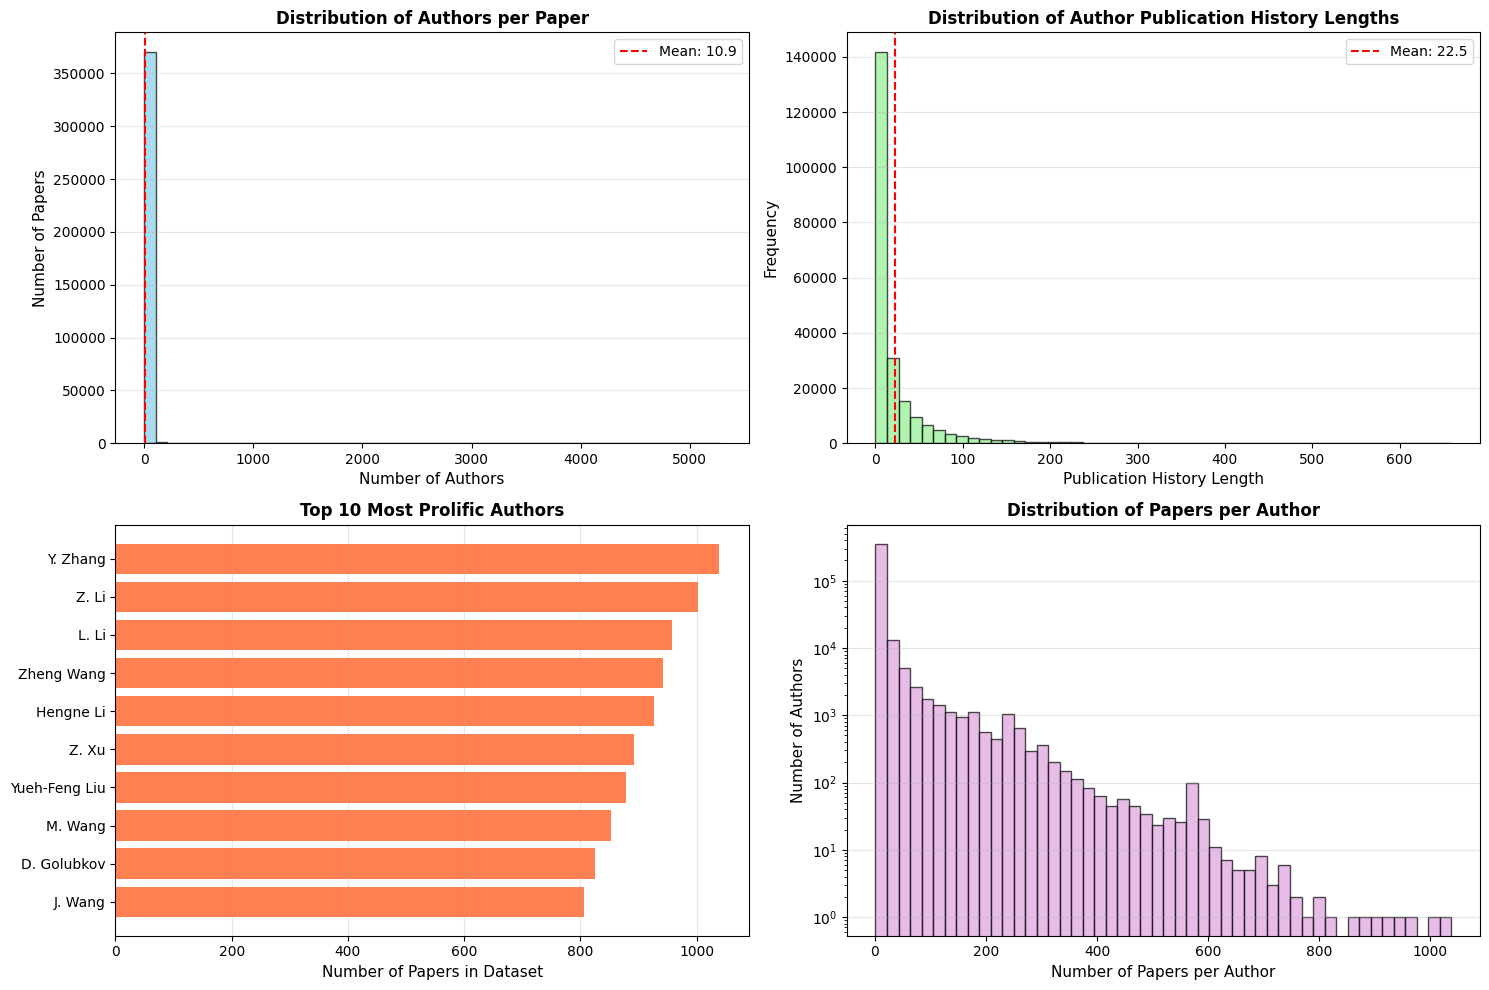

In [5]:
## 3. Author Entity Analysis

# Extract all authors
all_authors = {}
authors_per_paper = []
pub_history_lengths = []

for paper in papers:
    authors = paper.get('authors', [])
    authors_per_paper.append(len(authors))
    
    for author in authors:
        author_id = author.get('author_id')
        if author_id:
            if author_id not in all_authors:
                all_authors[author_id] = {
                    'name': author.get('name'),
                    'paper_count': 0,
                    'pub_history_length': len(author.get('publication_history', []))
                }
            all_authors[author_id]['paper_count'] += 1
            
            # Track publication history lengths
            if 'publication_history' in author:
                pub_history_lengths.append(len(author['publication_history']))

# Get most prolific authors
prolific_authors = sorted(all_authors.items(), 
                         key=lambda x: x[1]['paper_count'], 
                         reverse=True)[:10]

print("=" * 80)
print("AUTHOR ENTITY ANALYSIS")
print("=" * 80)
print(f"Total unique authors: {len(all_authors):,}")
print(f"Papers with authors: {sum(1 for p in papers if p.get('authors')):,}")
print(f"\nAuthors per paper:")
print(f"  Mean: {np.mean(authors_per_paper):.2f}")
print(f"  Median: {np.median(authors_per_paper):.1f}")
print(f"  Min: {min(authors_per_paper)}")
print(f"  Max: {max(authors_per_paper)}")

if pub_history_lengths:
    print(f"\nPublication history lengths:")
    print(f"  Mean: {np.mean(pub_history_lengths):.2f}")
    print(f"  Median: {np.median(pub_history_lengths):.1f}")
    print(f"  Min: {min(pub_history_lengths)}")
    print(f"  Max: {max(pub_history_lengths)}")

print(f"\nTop 10 Most Prolific Authors (by paper count in dataset):")
for i, (author_id, info) in enumerate(prolific_authors, 1):
    print(f"  {i:2d}. {info['name']:40s} - {info['paper_count']:3d} papers, "
          f"{info['pub_history_length']:3d} in history")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Authors per paper distribution
ax = axes[0, 0]
ax.hist(authors_per_paper, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax.set_xlabel('Number of Authors', fontsize=11)
ax.set_ylabel('Number of Papers', fontsize=11)
ax.set_title('Distribution of Authors per Paper', fontsize=12, fontweight='bold')
ax.axvline(np.mean(authors_per_paper), color='red', linestyle='--', 
           label=f'Mean: {np.mean(authors_per_paper):.1f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Publication history length distribution
if pub_history_lengths:
    ax = axes[0, 1]
    ax.hist(pub_history_lengths, bins=50, edgecolor='black', color='lightgreen', alpha=0.7)
    ax.set_xlabel('Publication History Length', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Author Publication History Lengths', fontsize=12, fontweight='bold')
    ax.axvline(np.mean(pub_history_lengths), color='red', linestyle='--',
               label=f'Mean: {np.mean(pub_history_lengths):.1f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Top prolific authors
ax = axes[1, 0]
names = [info['name'][:30] for _, info in prolific_authors]
counts = [info['paper_count'] for _, info in prolific_authors]
ax.barh(names, counts, color='coral')
ax.set_xlabel('Number of Papers in Dataset', fontsize=11)
ax.set_title('Top 10 Most Prolific Authors', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Paper count distribution for authors
ax = axes[1, 1]
paper_counts = [info['paper_count'] for info in all_authors.values()]
ax.hist(paper_counts, bins=min(50, max(paper_counts)), 
        edgecolor='black', color='plum', alpha=0.7)
ax.set_xlabel('Number of Papers per Author', fontsize=11)
ax.set_ylabel('Number of Authors', fontsize=11)
ax.set_title('Distribution of Papers per Author', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

CITATION/REFERENCE NETWORK ANALYSIS
Papers with key_references: 209,470
Total unique referenced papers: 154,394
Total reference relationships: 669,754

Key references per paper (for papers with refs):
  Mean: 3.20
  Median: 3.0
  Min: 1
  Max: 10

Top 15 Most Cited Papers (in key_references):
   1. [6059 citations] BERT: Pre-training of Deep Bidirectional Transformers for Language Und...
   2. [5488 citations] Adam: A Method for Stochastic Optimization
   3. [5172 citations] Attention Is All You Need
   4. [2245 citations] Very Deep Convolutional Networks for Large-Scale Image Recognition
   5. [1930 citations] RoBERTa: A Robustly Optimized BERT Pretraining Approach
   6. [1877 citations] Semi-Supervised Classification with Graph Convolutional Networks
   7. [1809 citations] U-Net: Convolutional Networks for Biomedical Image Segmentation
   8. [1754 citations] Language Models are Few-Shot Learners
   9. [1741 citations] Microsoft COCO: Common Objects in Context
  10. [1618 citations] A

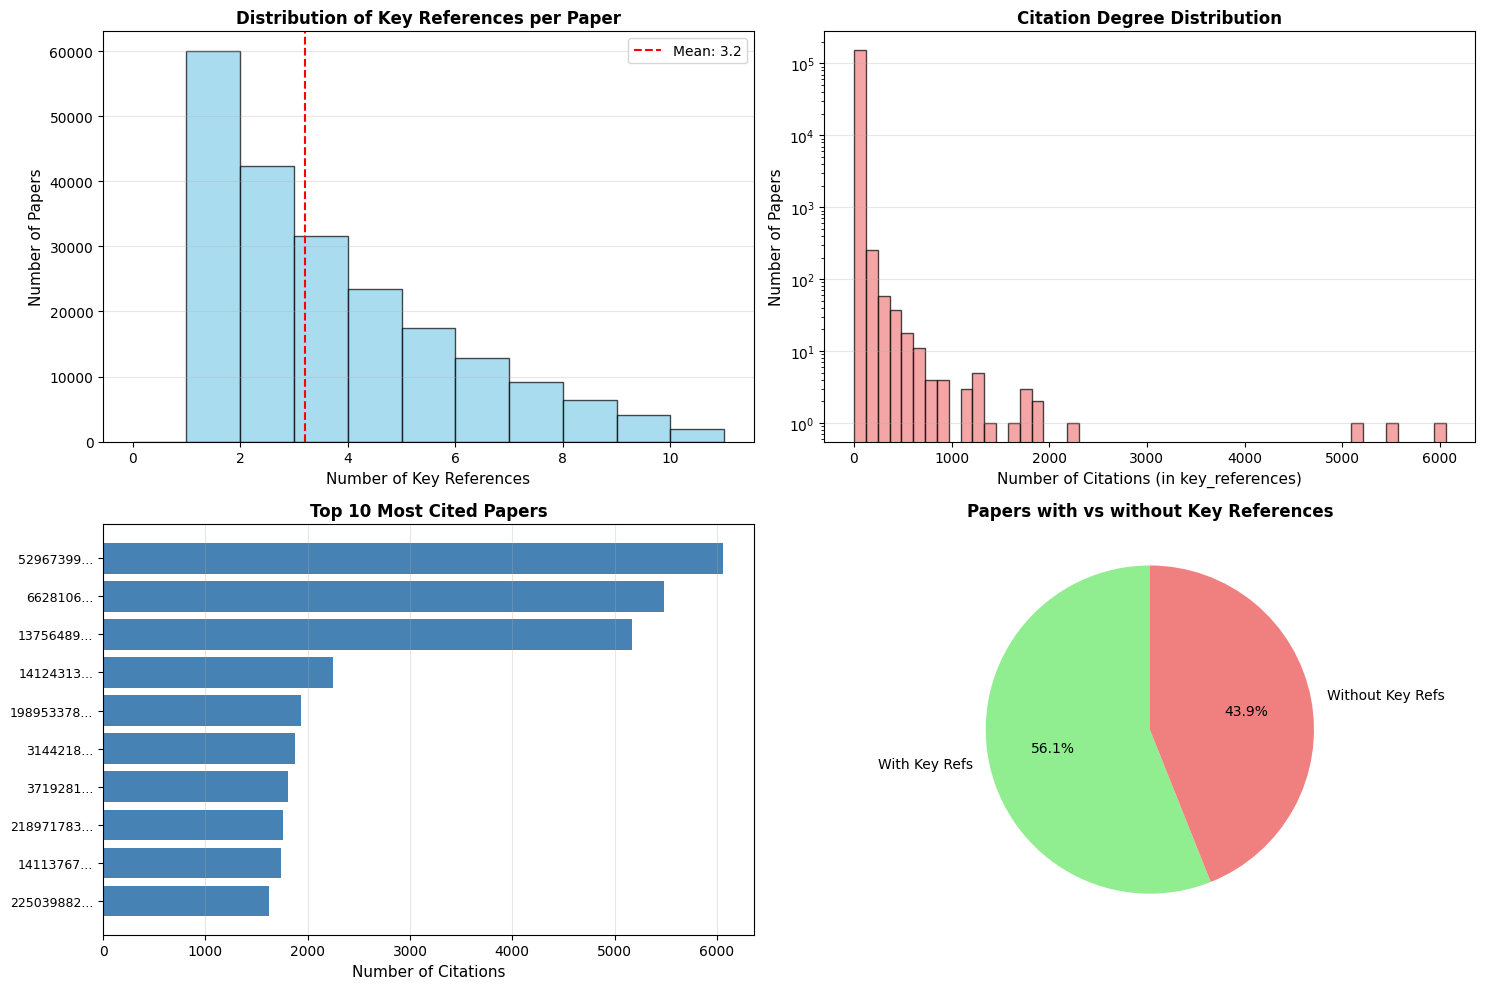

In [6]:
## 4. Citation/Reference Network Analysis

# Extract all references and count citations
reference_counter = Counter()
papers_with_refs = 0
refs_per_paper = []

for paper in papers:
    key_refs = paper.get('key_references', [])
    if key_refs:
        papers_with_refs += 1
        refs_per_paper.append(len(key_refs))
        
        for ref in key_refs:
            ref_id = ref.get('corpus_id')
            if ref_id:
                reference_counter[ref_id] += 1

# Get most cited papers
most_cited = reference_counter.most_common(15)

# Map corpus_id to paper title for most cited papers
corpus_id_to_title = {p['corpus_id']: p.get('title', 'Unknown') for p in papers}

print("=" * 80)
print("CITATION/REFERENCE NETWORK ANALYSIS")
print("=" * 80)
print(f"Papers with key_references: {papers_with_refs:,}")
print(f"Total unique referenced papers: {len(reference_counter):,}")
print(f"Total reference relationships: {sum(reference_counter.values()):,}")

if refs_per_paper:
    print(f"\nKey references per paper (for papers with refs):")
    print(f"  Mean: {np.mean(refs_per_paper):.2f}")
    print(f"  Median: {np.median(refs_per_paper):.1f}")
    print(f"  Min: {min(refs_per_paper)}")
    print(f"  Max: {max(refs_per_paper)}")

print(f"\nTop 15 Most Cited Papers (in key_references):")
for i, (corpus_id, count) in enumerate(most_cited, 1):
    title = corpus_id_to_title.get(corpus_id, f"External paper {corpus_id}")
    title_short = title[:70] + "..." if len(title) > 70 else title
    print(f"  {i:2d}. [{count:3d} citations] {title_short}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# References per paper distribution
if refs_per_paper:
    ax = axes[0, 0]
    ax.hist(refs_per_paper, bins=range(0, max(refs_per_paper)+2), 
            edgecolor='black', color='skyblue', alpha=0.7)
    ax.set_xlabel('Number of Key References', fontsize=11)
    ax.set_ylabel('Number of Papers', fontsize=11)
    ax.set_title('Distribution of Key References per Paper', fontsize=12, fontweight='bold')
    ax.axvline(np.mean(refs_per_paper), color='red', linestyle='--',
               label=f'Mean: {np.mean(refs_per_paper):.1f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Citation degree distribution (log scale)
ax = axes[0, 1]
citation_counts = list(reference_counter.values())
ax.hist(citation_counts, bins=50, edgecolor='black', color='lightcoral', alpha=0.7)
ax.set_xlabel('Number of Citations (in key_references)', fontsize=11)
ax.set_ylabel('Number of Papers', fontsize=11)
ax.set_title('Citation Degree Distribution', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

# Top cited papers
ax = axes[1, 0]
top_ids = [corpus_id for corpus_id, _ in most_cited[:10]]
top_counts = [count for _, count in most_cited[:10]]
labels = [f"{cid[:10]}..." for cid in top_ids]
ax.barh(range(len(top_counts)), top_counts, color='steelblue')
ax.set_yticks(range(len(top_counts)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Number of Citations', fontsize=11)
ax.set_title('Top 10 Most Cited Papers', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Papers with vs without references
ax = axes[1, 1]
ref_status = ['With Key Refs', 'Without Key Refs']
ref_counts = [papers_with_refs, len(papers) - papers_with_refs]
colors = ['lightgreen', 'lightcoral']
wedges, texts, autotexts = ax.pie(ref_counts, labels=ref_status, autopct='%1.1f%%',
                                    colors=colors, startangle=90)
ax.set_title('Papers with vs without Key References', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

CATEGORY ANALYSIS
Total unique categories: 173
Total papers: 373,716

Categories per paper:
  Mean: 1.97
  Median: 2.0
  Min: 1
  Max: 10

Top 20 Categories (all papers):
   1. cs.LG           - 116,855 papers (31.27%)
   2. cs.CV           - 87,555 papers (23.43%)
   3. cs.AI           - 60,670 papers (16.23%)
   4. cs.CL           - 46,617 papers (12.47%)
   5. stat.ML         - 39,515 papers (10.57%)
   6. cs.RO           - 17,503 papers ( 4.68%)
   7. cs.IT           - 15,290 papers ( 4.09%)
   8. math.IT         - 15,290 papers ( 4.09%)
   9. math.OC         - 14,206 papers ( 3.80%)
  10. eess.IV         - 13,180 papers ( 3.53%)
  11. cs.CR           - 12,877 papers ( 3.45%)
  12. eess.SP         - 10,366 papers ( 2.77%)
  13. eess.AS         -  9,934 papers ( 2.66%)
  14. cs.SY           -  9,767 papers ( 2.61%)
  15. cs.IR           -  9,684 papers ( 2.59%)
  16. quant-ph        -  9,294 papers ( 2.49%)
  17. cs.SD           -  9,108 papers ( 2.44%)
  18. cs.SI           -  7,48

/tmp/ipykernel_16795/2699934299.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


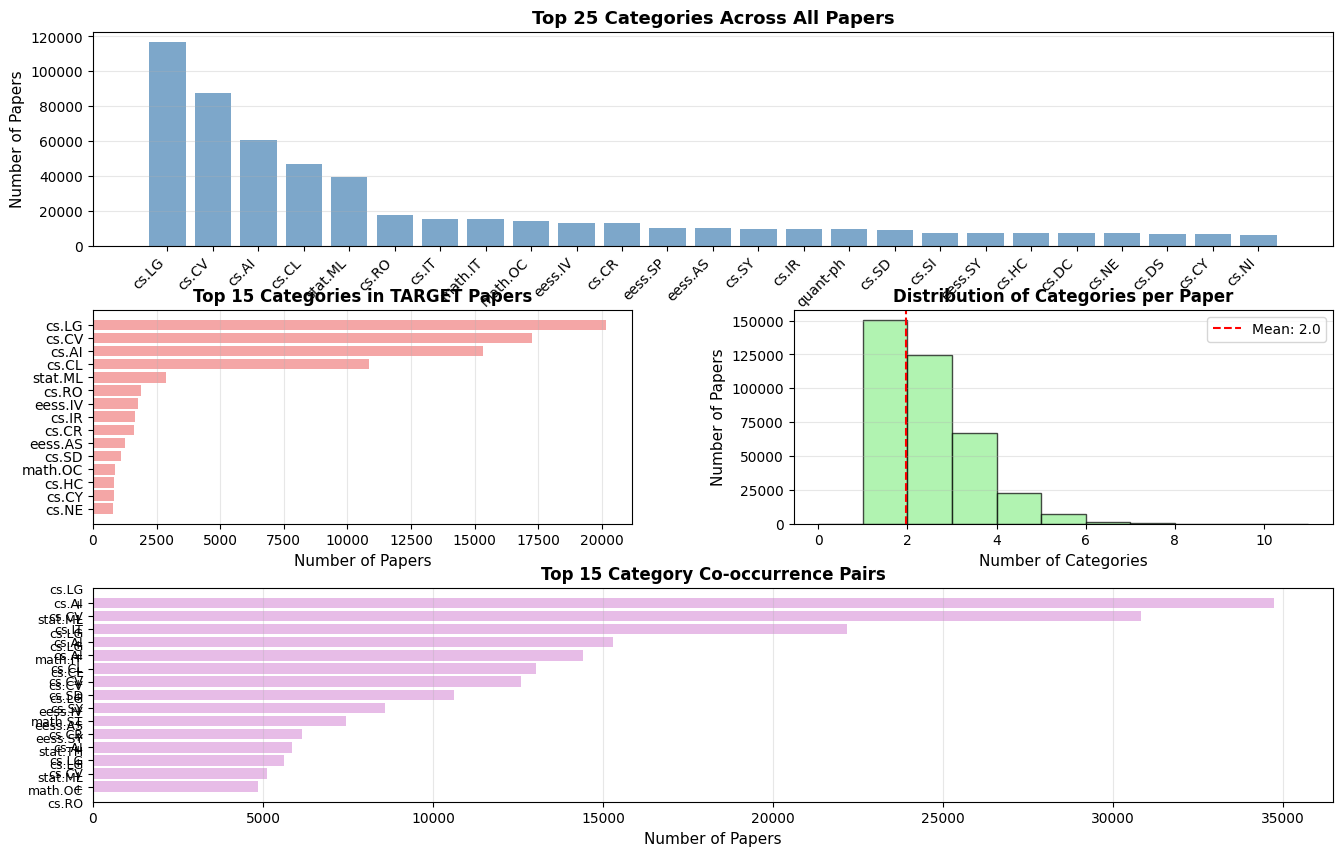

In [7]:
## 5. Category Analysis

# Extract all categories
category_counter = Counter()
categories_per_paper = []
category_pairs = Counter()

for paper in papers:
    cats = paper.get('categories', [])
    categories_per_paper.append(len(cats))
    
    for cat in cats:
        category_counter[cat] += 1
    
    # Track category co-occurrence (for papers with multiple categories)
    if len(cats) > 1:
        for i, cat1 in enumerate(cats):
            for cat2 in cats[i+1:]:
                pair = tuple(sorted([cat1, cat2]))
                category_pairs[pair] += 1

# Get target papers (to see what categories are in the main dataset)
target_papers = [p for p in papers if 'target' in p.get('roles', [])]
target_categories = Counter()
for paper in target_papers:
    for cat in paper.get('categories', []):
        target_categories[cat] += 1

print("=" * 80)
print("CATEGORY ANALYSIS")
print("=" * 80)
print(f"Total unique categories: {len(category_counter)}")
print(f"Total papers: {len(papers):,}")

print(f"\nCategories per paper:")
print(f"  Mean: {np.mean(categories_per_paper):.2f}")
print(f"  Median: {np.median(categories_per_paper):.1f}")
print(f"  Min: {min(categories_per_paper)}")
print(f"  Max: {max(categories_per_paper)}")

print(f"\nTop 20 Categories (all papers):")
for i, (cat, count) in enumerate(category_counter.most_common(20), 1):
    pct = count / len(papers) * 100
    print(f"  {i:2d}. {cat:15s} - {count:6,} papers ({pct:5.2f}%)")

print(f"\nTop 10 Categories in TARGET papers:")
for i, (cat, count) in enumerate(target_categories.most_common(10), 1):
    pct = count / len(target_papers) * 100
    print(f"  {i:2d}. {cat:15s} - {count:5,} papers ({pct:5.2f}%)")

print(f"\nTop 10 Category Pairs (co-occurrence):")
for i, (pair, count) in enumerate(category_pairs.most_common(10), 1):
    print(f"  {i:2d}. {pair[0]:15s} + {pair[1]:15s} - {count:5,} papers")

# Visualizations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Top categories bar chart
ax1 = fig.add_subplot(gs[0, :])
top_cats = category_counter.most_common(25)
cats, counts = zip(*top_cats)
ax1.bar(range(len(cats)), counts, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(cats)))
ax1.set_xticklabels(cats, rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Number of Papers', fontsize=11)
ax1.set_title('Top 25 Categories Across All Papers', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Target paper categories
ax2 = fig.add_subplot(gs[1, 0])
target_top = target_categories.most_common(15)
if target_top:
    t_cats, t_counts = zip(*target_top)
    ax2.barh(range(len(t_cats)), t_counts, color='lightcoral', alpha=0.7)
    ax2.set_yticks(range(len(t_cats)))
    ax2.set_yticklabels(t_cats, fontsize=10)
    ax2.set_xlabel('Number of Papers', fontsize=11)
    ax2.set_title('Top 15 Categories in TARGET Papers', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

# Categories per paper distribution
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(categories_per_paper, bins=range(0, max(categories_per_paper)+2),
         edgecolor='black', color='lightgreen', alpha=0.7)
ax3.set_xlabel('Number of Categories', fontsize=11)
ax3.set_ylabel('Number of Papers', fontsize=11)
ax3.set_title('Distribution of Categories per Paper', fontsize=12, fontweight='bold')
ax3.axvline(np.mean(categories_per_paper), color='red', linestyle='--',
            label=f'Mean: {np.mean(categories_per_paper):.1f}')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Category co-occurrence heatmap (top pairs)
ax4 = fig.add_subplot(gs[2, :])
top_pairs = category_pairs.most_common(15)
if top_pairs:
    pair_labels = [f"{p[0]}\n+\n{p[1]}" for p, _ in top_pairs]
    pair_counts = [c for _, c in top_pairs]
    ax4.barh(range(len(pair_labels)), pair_counts, color='plum', alpha=0.7)
    ax4.set_yticks(range(len(pair_labels)))
    ax4.set_yticklabels(pair_labels, fontsize=9)
    ax4.set_xlabel('Number of Papers', fontsize=11)
    ax4.set_title('Top 15 Category Co-occurrence Pairs', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

TEMPORAL ANALYSIS
Papers with dates: 373,716 / 373,716

Date range (all papers):
  Earliest: 1989-10-26
  Latest: 2024-09-30
  Span: 34.9 years

Date range by role:
  target                                       
    2023-10-01 to 2024-09-30 (44,990 papers)
  target.author.publication_history            
    1991-12-17 to 2024-09-29 (295,897 papers)
  target.author.publication_history.key_reference
    1989-10-26 to 2024-09-23 (149,314 papers)
  target.key_reference                         
    1992-07-01 to 2024-09-23 (50,653 papers)

Top 10 years by paper count:
   1. 2023 - 60,550 papers (16.20%)
   2. 2024 - 53,620 papers (14.35%)
   3. 2022 - 45,535 papers (12.18%)
   4. 2021 - 41,476 papers (11.10%)
   5. 2020 - 38,189 papers (10.22%)
   6. 2019 - 29,926 papers ( 8.01%)
   7. 2018 - 23,243 papers ( 6.22%)
   8. 2017 - 16,925 papers ( 4.53%)
   9. 2016 - 12,466 papers ( 3.34%)
  10. 2015 -  9,397 papers ( 2.51%)


/tmp/ipykernel_16795/4142942922.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


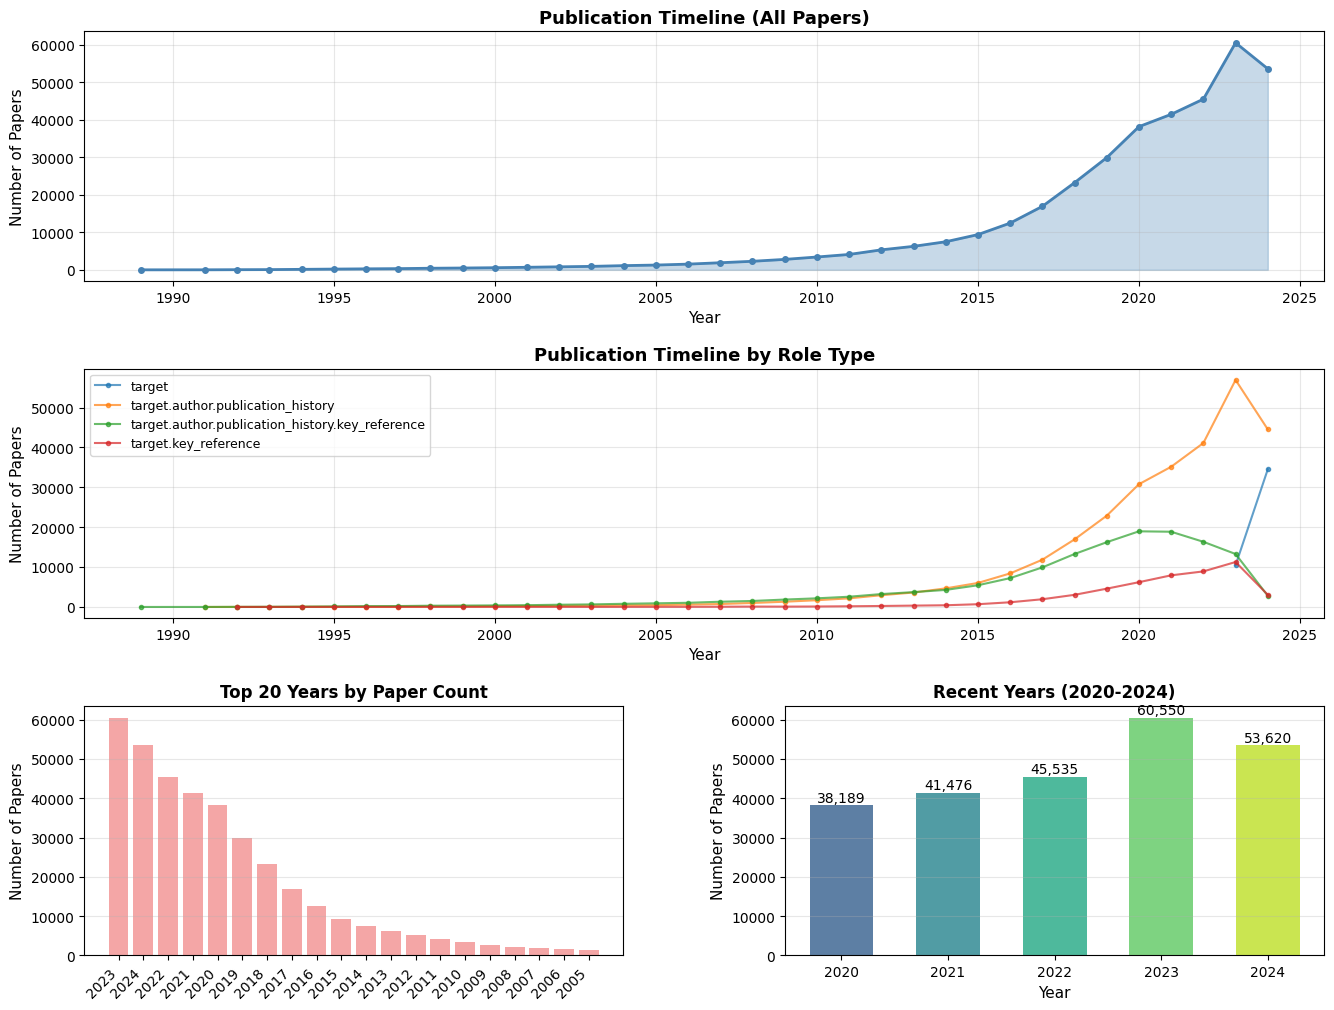

In [8]:
## 6. Temporal Analysis

from dateutil import parser
from collections import defaultdict

# Parse dates and organize by role
date_by_role = defaultdict(list)
all_dates = []
date_strings = []

for paper in papers:
    date_str = paper.get('date')
    if date_str:
        try:
            date_obj = parser.parse(date_str)
            all_dates.append(date_obj)
            date_strings.append(date_str)
            
            # Track by role
            for role in paper.get('roles', []):
                date_by_role[role].append(date_obj)
        except:
            pass

# Get year distribution
year_counter = Counter()
year_by_role = defaultdict(Counter)

for paper in papers:
    date_str = paper.get('date')
    if date_str:
        try:
            year = parser.parse(date_str).year
            year_counter[year] += 1
            
            for role in paper.get('roles', []):
                year_by_role[role][year] += 1
        except:
            pass

print("=" * 80)
print("TEMPORAL ANALYSIS")
print("=" * 80)
print(f"Papers with dates: {len(all_dates):,} / {len(papers):,}")

if all_dates:
    print(f"\nDate range (all papers):")
    print(f"  Earliest: {min(all_dates).strftime('%Y-%m-%d')}")
    print(f"  Latest: {max(all_dates).strftime('%Y-%m-%d')}")
    print(f"  Span: {(max(all_dates) - min(all_dates)).days / 365.25:.1f} years")
    
    print(f"\nDate range by role:")
    for role in sorted(date_by_role.keys()):
        dates = date_by_role[role]
        if dates:
            print(f"  {role:45s}")
            print(f"    {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')} "
                  f"({len(dates):,} papers)")
    
    print(f"\nTop 10 years by paper count:")
    for i, (year, count) in enumerate(year_counter.most_common(10), 1):
        pct = count / len(all_dates) * 100
        print(f"  {i:2d}. {year} - {count:6,} papers ({pct:5.2f}%)")

# Visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Overall timeline
ax1 = fig.add_subplot(gs[0, :])
years_sorted = sorted(year_counter.keys())
counts = [year_counter[y] for y in years_sorted]
ax1.plot(years_sorted, counts, marker='o', linewidth=2, markersize=4, color='steelblue')
ax1.fill_between(years_sorted, counts, alpha=0.3, color='steelblue')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Papers', fontsize=11)
ax1.set_title('Publication Timeline (All Papers)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Timeline by role
ax2 = fig.add_subplot(gs[1, :])
for role in sorted(year_by_role.keys()):
    role_years = year_by_role[role]
    years = sorted(role_years.keys())
    counts = [role_years[y] for y in years]
    ax2.plot(years, counts, marker='o', linewidth=1.5, markersize=3, label=role, alpha=0.7)

ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Number of Papers', fontsize=11)
ax2.set_title('Publication Timeline by Role Type', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Top years bar chart
ax3 = fig.add_subplot(gs[2, 0])
top_years = year_counter.most_common(20)
years_top, counts_top = zip(*top_years)
ax3.bar(range(len(years_top)), counts_top, color='lightcoral', alpha=0.7)
ax3.set_xticks(range(len(years_top)))
ax3.set_xticklabels(years_top, rotation=45, ha='right')
ax3.set_ylabel('Number of Papers', fontsize=11)
ax3.set_title('Top 20 Years by Paper Count', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Recent years (2020-2024)
ax4 = fig.add_subplot(gs[2, 1])
recent_years = [y for y in range(2020, 2025) if y in year_counter]
recent_counts = [year_counter[y] for y in recent_years]
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(recent_years)))
bars = ax4.bar(recent_years, recent_counts, color=colors_gradient, alpha=0.8, width=0.6)
ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Number of Papers', fontsize=11)
ax4.set_title('Recent Years (2020-2024)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, recent_counts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

COMPREHENSIVE DATASET SUMMARY

Dataset Overview:
--------------------------------------------------------------------------------
  Total Papers                  : 373,716
  Processing Stages             : 6
  Data File Size                : ~1.0 GB

Entity Types (by Role):
--------------------------------------------------------------------------------
  target.author.publication_history: 295,897 (79.2%)
  target.author.publication_history.key_reference: 149,314 (40.0%)
  target.key_reference          : 50,653 (13.6%)
  target                        : 44,990 (12.0%)

Authors:
--------------------------------------------------------------------------------
  Unique Authors                : 388,712
  Papers with Authors           : 306,045
  Avg Authors per Paper         : 10.91
  Max Authors in Paper          : 5278

References:
--------------------------------------------------------------------------------
  Papers with Key Refs          : 209,470
  Unique Referenced Papers      : 15

/tmp/ipykernel_16795/3103469073.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/root/.conda/envs/prescience/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/prescience/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/prescience/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/prescience/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans Mono.
  

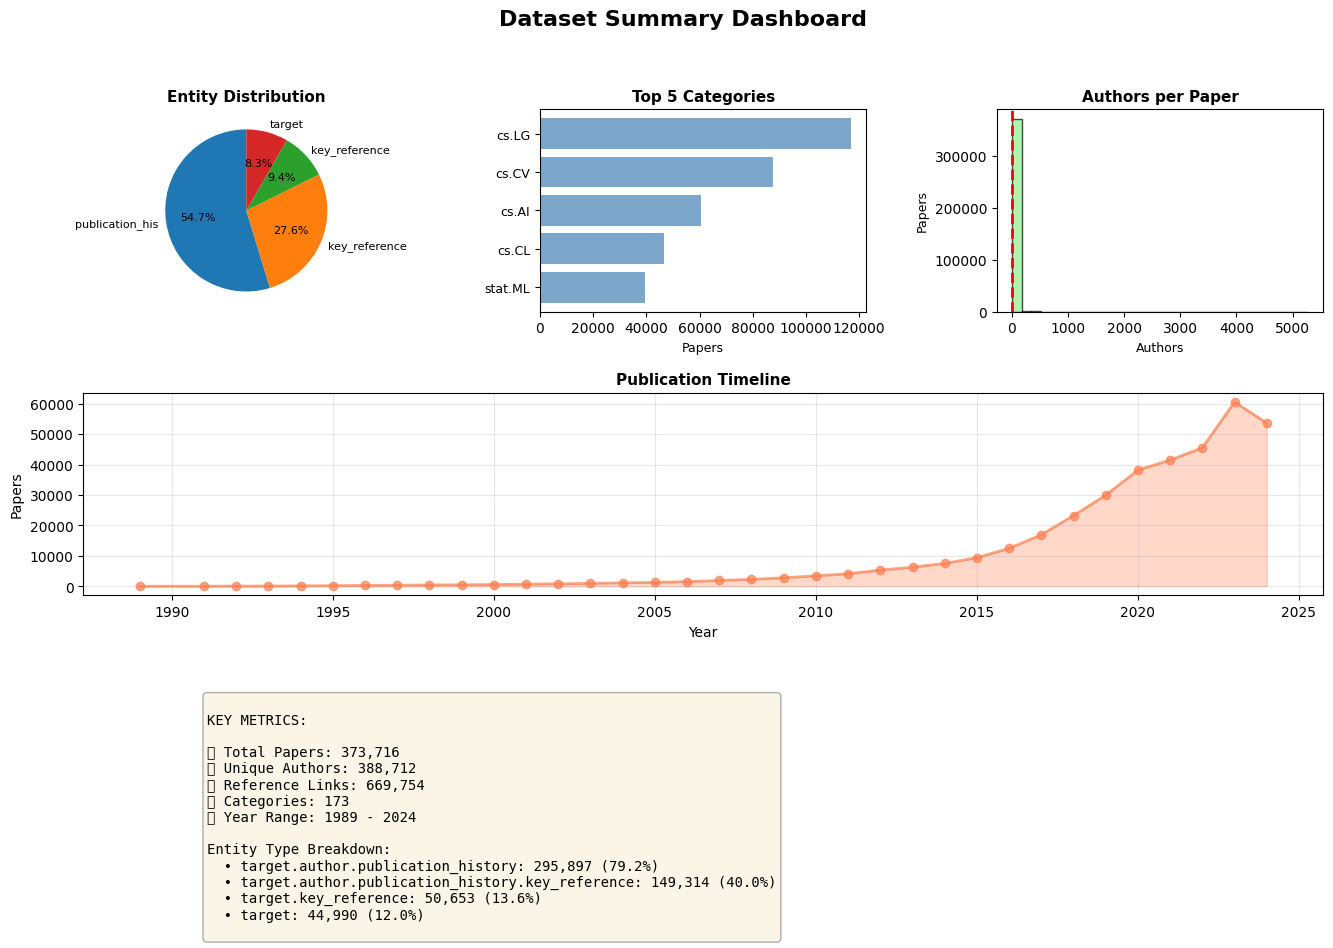


ANALYSIS COMPLETE!


In [9]:
## 7. Summary Statistics

# Compile all key statistics
summary = {
    'Dataset Overview': {
        'Total Papers': f"{len(papers):,}",
        'Processing Stages': len(metadata),
        'Data File Size': '~1.0 GB'
    },
    'Entity Types (by Role)': {
        role: f"{count:,} ({count/len(papers)*100:.1f}%)" 
        for role, count in role_counter.most_common()
    },
    'Authors': {
        'Unique Authors': f"{len(all_authors):,}",
        'Papers with Authors': f"{sum(1 for p in papers if p.get('authors')):,}",
        'Avg Authors per Paper': f"{np.mean(authors_per_paper):.2f}",
        'Max Authors in Paper': f"{max(authors_per_paper)}"
    },
    'References': {
        'Papers with Key Refs': f"{papers_with_refs:,}",
        'Unique Referenced Papers': f"{len(reference_counter):,}",
        'Total Reference Links': f"{sum(reference_counter.values()):,}",
        'Avg Refs per Paper (with refs)': f"{np.mean(refs_per_paper):.2f}" if refs_per_paper else "N/A"
    },
    'Categories': {
        'Unique Categories': f"{len(category_counter)}",
        'Top Category': f"{category_counter.most_common(1)[0][0]} ({category_counter.most_common(1)[0][1]:,} papers)",
        'Avg Categories per Paper': f"{np.mean(categories_per_paper):.2f}"
    },
    'Temporal': {
        'Papers with Dates': f"{len(all_dates):,}",
        'Date Range': f"{min(all_dates).strftime('%Y-%m-%d')} to {max(all_dates).strftime('%Y-%m-%d')}" if all_dates else "N/A",
        'Time Span': f"{(max(all_dates) - min(all_dates)).days / 365.25:.1f} years" if all_dates else "N/A",
        'Most Productive Year': f"{year_counter.most_common(1)[0][0]} ({year_counter.most_common(1)[0][1]:,} papers)" if year_counter else "N/A"
    }
}

print("=" * 80)
print("COMPREHENSIVE DATASET SUMMARY")
print("=" * 80)

for section, stats in summary.items():
    print(f"\n{section}:")
    print("-" * 80)
    for key, value in stats.items():
        print(f"  {key:30s}: {value}")

print("\n" + "=" * 80)

# Create a summary table
summary_data = []
summary_data.append(['METRIC', 'VALUE'])
summary_data.append(['=' * 40, '=' * 40])

for section, stats in summary.items():
    summary_data.append([f'\n{section.upper()}', ''])
    for key, value in stats.items():
        summary_data.append([f'  {key}', str(value)])

summary_df = pd.DataFrame(summary_data[2:], columns=summary_data[0])

print("\n\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))

# Create a visual summary dashboard
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Dataset Summary Dashboard', fontsize=16, fontweight='bold', y=0.98)
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# 1. Entity types pie
ax1 = fig.add_subplot(gs[0, 0])
role_names = [r.split('.')[-1][:15] for r in role_df['Role']]
ax1.pie(role_df['Count'], labels=role_names, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
ax1.set_title('Entity Distribution', fontsize=11, fontweight='bold')

# 2. Top categories
ax2 = fig.add_subplot(gs[0, 1])
top_5_cats = category_counter.most_common(5)
cats, counts = zip(*top_5_cats)
ax2.barh(range(len(cats)), counts, color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(cats)))
ax2.set_yticklabels(cats, fontsize=9)
ax2.set_xlabel('Papers', fontsize=9)
ax2.set_title('Top 5 Categories', fontsize=11, fontweight='bold')
ax2.invert_yaxis()

# 3. Authors per paper
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(authors_per_paper, bins=30, edgecolor='black', color='lightgreen', alpha=0.7)
ax3.set_xlabel('Authors', fontsize=9)
ax3.set_ylabel('Papers', fontsize=9)
ax3.set_title('Authors per Paper', fontsize=11, fontweight='bold')
ax3.axvline(np.mean(authors_per_paper), color='red', linestyle='--', linewidth=2)

# 4. Timeline
ax4 = fig.add_subplot(gs[1, :])
years_sorted = sorted(year_counter.keys())
counts = [year_counter[y] for y in years_sorted]
ax4.plot(years_sorted, counts, marker='o', linewidth=2, color='coral', alpha=0.7)
ax4.fill_between(years_sorted, counts, alpha=0.3, color='coral')
ax4.set_xlabel('Year', fontsize=10)
ax4.set_ylabel('Papers', fontsize=10)
ax4.set_title('Publication Timeline', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Key metrics as text
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')
metrics_text = f"""
KEY METRICS:

📊 Total Papers: {len(papers):,}
👥 Unique Authors: {len(all_authors):,}
🔗 Reference Links: {sum(reference_counter.values()):,}
📁 Categories: {len(category_counter)}
📅 Year Range: {min(all_dates).year if all_dates else 'N/A'} - {max(all_dates).year if all_dates else 'N/A'}

Entity Type Breakdown:
"""

for role, count in role_counter.most_common():
    pct = count/len(papers)*100
    metrics_text += f"  • {role}: {count:,} ({pct:.1f}%)\n"

ax5.text(0.1, 0.9, metrics_text, transform=ax5.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)